In [3]:
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

engine = create_engine("postgresql://ritu@localhost:5435/spend_analytics")
print("Connected")

Connected


## SQL Analysis — Business Questions
Each query below answers a specific business question that feeds into the final dashboard and recommendations.

Query 1: Total Spend by Category

In [5]:
import pandas as pd
from sqlalchemy import text

pd.read_sql(text("""
SELECT column_name
FROM information_schema.columns
WHERE table_schema='public' AND table_name='procurement'
ORDER BY ordinal_position;
"""), engine)

,column_name
0,PO_ID
1,PO_Date
2,Invoice_Date
3,Payment_Date
4,Category
5,Item_Description
6,Supplier_Name
7,Business_Unit
8,Quantity
9,Unit_Price


,Category,total_POs,Unique_Suppliers,Total_Spend,pct_of_total
0,Professional Services,1199,34,3.201749e+08,31.62
1,IT & Software,1401,35,2.214203e+08,21.87
2,Logistics,1645,40,1.764012e+08,17.42
3,Raw Materials,2166,42,1.513012e+08,14.94
4,Marketing,373,17,7.226167e+07,7.14
5,MRO,1806,36,3.575323e+07,3.53
6,Facilities,795,24,3.160839e+07,3.12
7,Office Supplies,615,21,3.670458e+06,0.36


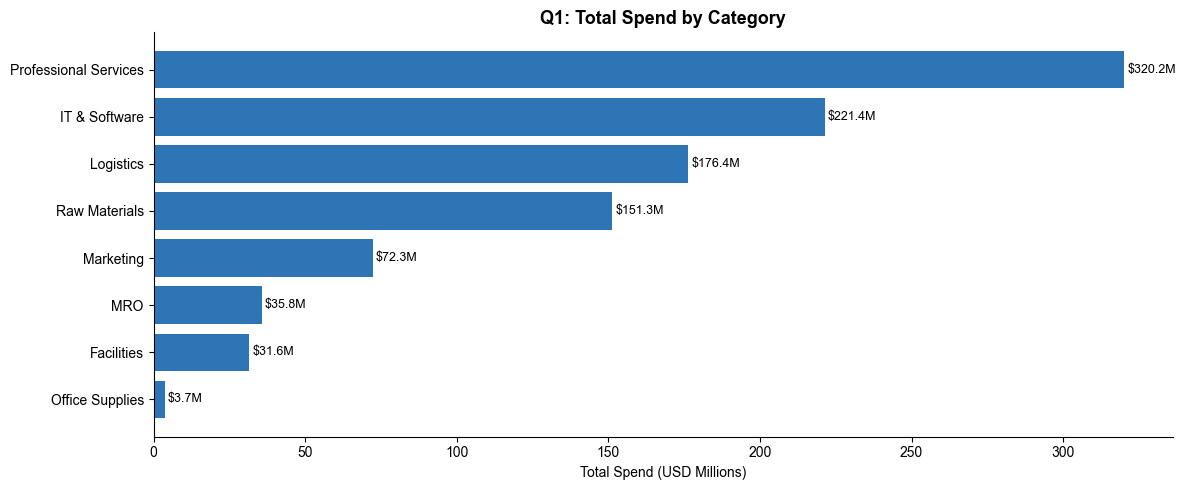

In [6]:
q1 = """
SELECT
    "Category" AS "Category",
    COUNT(DISTINCT "PO_ID") AS "total_POs",
    COUNT(DISTINCT "Supplier_Name") AS "Unique_Suppliers",
    ROUND(CAST(SUM("Total_Cost") AS numeric), 2) AS "Total_Spend",
    ROUND(CAST(SUM("Total_Cost") * 100.0 / SUM(SUM("Total_Cost")) OVER() AS numeric), 2) AS "pct_of_total"
FROM procurement
GROUP BY "Category"
ORDER BY "Total_Spend" DESC;
"""

df_q1 = pd.read_sql(text(q1), engine)
display(df_q1)

# Visualize
fig, ax = plt.subplots()
bars = ax.barh(df_q1['Category'][::-1], df_q1['Total_Spend'][::-1]/1e6, color='#2E75B6')
for bar, val in zip(bars, df_q1['Total_Spend'][::-1]):
    ax.text(val/1e6 + 1, bar.get_y() + bar.get_height()/2, f'${val/1e6:.1f}M', va='center', fontsize=9)
ax.set_xlabel('Total Spend (USD Millions)')
ax.set_title('Q1: Total Spend by Category', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('sql_q1_spend_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

Query 2: Top 20 Suppliers by Spend

In [7]:
q2 = """
SELECT
    "Supplier_Name" AS supplier_name,
    "Category" AS category,
    COUNT(DISTINCT "PO_ID") AS po_count,
    ROUND(CAST(SUM("Total_Cost") AS numeric), 2) AS total_spend,
    ROUND(CAST(AVG("Unit_Price") AS numeric), 2) AS avg_unit_price,
    ROUND(CAST(SUM("Total_Cost") * 100.0 / SUM(SUM("Total_Cost")) OVER() AS numeric), 2) AS pct_of_total
FROM procurement
GROUP BY "Supplier_Name", "Category"
ORDER BY total_spend DESC
LIMIT 20;
"""

df_q2 = pd.read_sql(text(q2), engine)
display(df_q2)

# What % do top 5 suppliers represent?
top5_pct = df_q2['pct_of_total'].head(5).sum()
print(f"\nInsight: Top 5 suppliers represent {top5_pct:.1f}% of total spend")
print(f"Top supplier: {df_q2.iloc[0]['supplier_name']} — ${df_q2.iloc[0]['total_spend']/1e6:.1f}M")

,supplier_name,category,po_count,total_spend,avg_unit_price,pct_of_total
0,Apex Consulting Group,Professional Services,330,90890608.14,11436.51,8.98
1,Strategyfirst Partners,Professional Services,264,68596249.93,10695.76,6.77
2,Cloudtech Systems,IT & Software,357,62513079.65,7020.61,6.17
3,Legaledge Associates,Professional Services,220,58477227.74,10250.25,5.78
4,Financewise Advisory,Professional Services,200,51254759.18,9821.94,5.06
5,Swiftlogistics Group,Logistics,402,48445028.71,4669.96,4.78
6,Datacore Solutions,IT & Software,291,44018250.74,6175.35,4.35
7,Steelcore Industries,Raw Materials,514,39003100.09,2970.29,3.85
8,Netsecure Pro,IT & Software,227,34672441.26,5980.40,3.42
9,Hrpro Consultants,Professional Services,129,34504527.63,9856.60,3.41



Insight: Top 5 suppliers represent 32.8% of total spend
Top supplier: Apex Consulting Group — $90.9M


Query 3: Maverick Spend by Business Unit

,business_unit,total_spend,maverick_spend,contract_spend,maverick_pct
0,Marketing,1.080105e+08,47075295.82,6.093523e+07,43.6
1,Sales,1.034149e+08,37532265.88,6.588258e+07,36.3
2,R&D,6.582324e+07,22526877.52,4.329636e+07,34.2
3,Operations,2.524626e+08,74239019.38,1.782236e+08,29.4
4,IT,1.553790e+08,39466407.90,1.159126e+08,25.4
5,Supply Chain,1.371076e+08,27639540.58,1.094681e+08,20.2
6,HR,7.425242e+07,14639755.12,5.961266e+07,19.7
7,Finance,1.161411e+08,19406113.33,9.673500e+07,16.7


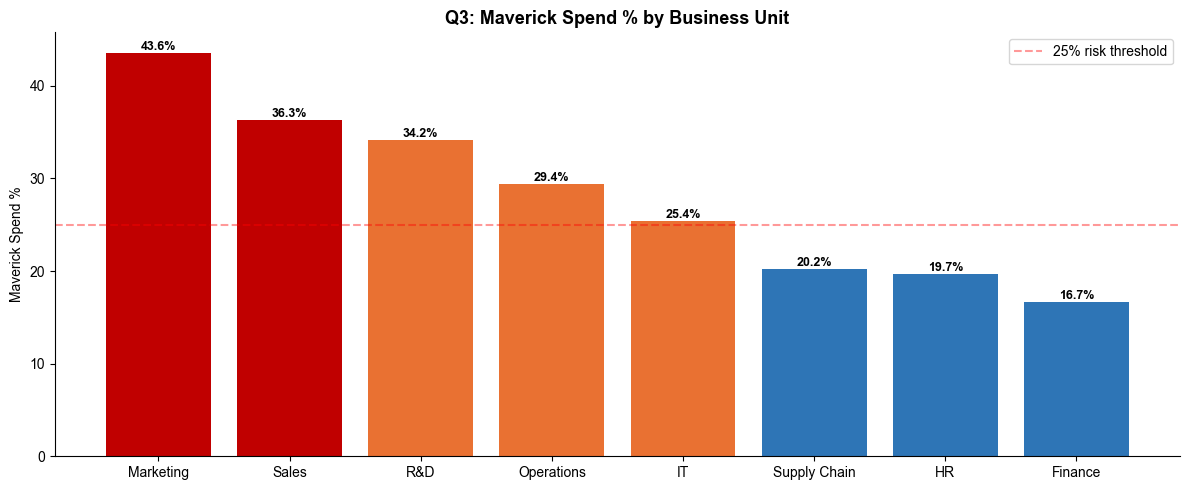


Insight: Total maverick spend = $282.5M


In [8]:
q3 = """
SELECT
    "Business_Unit" AS business_unit,
    ROUND(CAST(SUM("Total_Cost") AS numeric), 2) AS total_spend,
    ROUND(CAST(SUM(CASE WHEN "Contract_Flag" = 'N' THEN "Total_Cost" ELSE 0 END) AS numeric), 2) AS maverick_spend,
    ROUND(CAST(SUM(CASE WHEN "Contract_Flag" = 'Y' THEN "Total_Cost" ELSE 0 END) AS numeric), 2) AS contract_spend,
    ROUND(CAST(SUM(CASE WHEN "Contract_Flag" = 'N' THEN "Total_Cost" ELSE 0 END) * 100.0 
          / NULLIF(SUM("Total_Cost"), 0) AS numeric), 1) AS maverick_pct
FROM procurement
GROUP BY "Business_Unit"
ORDER BY maverick_pct DESC;
"""

df_q3 = pd.read_sql(text(q3), engine)
display(df_q3)

# Visualize
bar_colors = ['#C00000' if x > 35 else '#E97132' if x > 25 else '#2E75B6' for x in df_q3['maverick_pct']]
fig, ax = plt.subplots()
bars = ax.bar(df_q3['business_unit'], df_q3['maverick_pct'], color=bar_colors)
for bar, val in zip(bars, df_q3['maverick_pct']):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.3, f'{val}%', ha='center', fontsize=9, fontweight='bold')
ax.axhline(y=25, color='red', linestyle='--', alpha=0.4, label='25% risk threshold')
ax.set_ylabel('Maverick Spend %')
ax.set_title('Q3: Maverick Spend % by Business Unit', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('sql_q3_maverick_by_bu.png', dpi=150, bbox_inches='tight')
plt.show()

total_maverick = df_q3['maverick_spend'].sum()
print(f"\nInsight: Total maverick spend = ${total_maverick/1e6:.1f}M")

Query 4: Monthly Spend Trend

,month,monthly_spend,po_count,active_suppliers,month_label
0,2023-01-01,55358855.42,575,42,Jan 2023
1,2023-02-01,53027897.71,525,42,Feb 2023
2,2023-03-01,54410096.69,562,42,Mar 2023
3,2023-04-01,56305417.64,533,42,Apr 2023
4,2023-05-01,55816634.02,554,42,May 2023
5,2023-06-01,56005250.82,551,42,Jun 2023
6,2023-07-01,55878286.08,567,42,Jul 2023
7,2023-08-01,60226115.15,565,42,Aug 2023
8,2023-09-01,47306432.59,500,42,Sep 2023
9,2023-10-01,66329606.85,577,42,Oct 2023


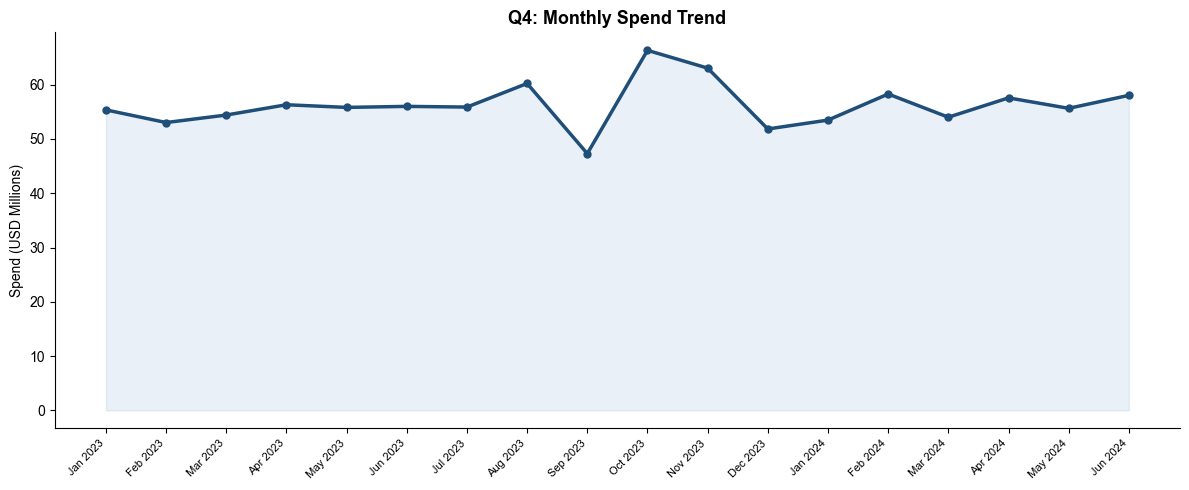

In [9]:
q4 = """
SELECT
    DATE_TRUNC('month', "PO_Date"::timestamp) AS month,
    ROUND(CAST(SUM("Total_Cost") AS numeric), 2) AS monthly_spend,
    COUNT(DISTINCT "PO_ID") AS po_count,
    COUNT(DISTINCT "Supplier_Name") AS active_suppliers
FROM procurement
GROUP BY DATE_TRUNC('month', "PO_Date"::timestamp)
ORDER BY month;
"""

df_q4 = pd.read_sql(text(q4), engine)
df_q4['month_label'] = pd.to_datetime(df_q4['month']).dt.strftime('%b %Y')
display(df_q4)

fig, ax = plt.subplots()
ax.plot(df_q4['month_label'], df_q4['monthly_spend']/1e6,
        color='#1F4E79', linewidth=2.5, marker='o', markersize=5)
ax.fill_between(range(len(df_q4)), df_q4['monthly_spend']/1e6, alpha=0.1, color='#2E75B6')
ax.set_xticks(range(len(df_q4)))
ax.set_xticklabels(df_q4['month_label'], rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Spend (USD Millions)')
ax.set_title('Q4: Monthly Spend Trend', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('sql_q4_monthly_trend.png', dpi=150, bbox_inches='tight')
plt.show()

Query 5: Supplier Consolidation Opportunity

In [10]:
q5 = """
SELECT
    "Category" AS category,
    COUNT(DISTINCT "Supplier_Name") AS supplier_count,
    ROUND(CAST(SUM("Total_Cost") AS numeric), 2) AS total_spend,
    ROUND(CAST(SUM("Total_Cost") / COUNT(DISTINCT "Supplier_Name") AS numeric), 2) AS avg_spend_per_supplier,
    CASE 
        WHEN COUNT(DISTINCT "Supplier_Name") >= 7 THEN 'High Fragmentation — Consolidate'
        WHEN COUNT(DISTINCT "Supplier_Name") >= 4 THEN 'Moderate Fragmentation — Review'
        ELSE 'Consolidated — Monitor'
    END AS recommendation
FROM procurement
GROUP BY "Category"
ORDER BY supplier_count DESC;
"""

df_q5 = pd.read_sql(text(q5), engine)
display(df_q5)

high_frag = df_q5[df_q5['recommendation'].str.contains('High')]
print(f"\nInsight: {len(high_frag)} categories flagged for consolidation")
print(f"Consolidation targets: {', '.join(high_frag['category'].tolist())}")

,category,supplier_count,total_spend,avg_spend_per_supplier,recommendation
0,Raw Materials,42,1.513012e+08,3602408.85,High Fragmentation — Consolidate
1,Logistics,40,1.764012e+08,4410030.87,High Fragmentation — Consolidate
2,MRO,36,3.575323e+07,993145.30,High Fragmentation — Consolidate
3,IT & Software,35,2.214203e+08,6326293.52,High Fragmentation — Consolidate
4,Professional Services,34,3.201749e+08,9416909.74,High Fragmentation — Consolidate
5,Facilities,24,3.160839e+07,1317016.45,High Fragmentation — Consolidate
6,Office Supplies,21,3.670458e+06,174783.73,High Fragmentation — Consolidate
7,Marketing,17,7.226167e+07,4250686.50,High Fragmentation — Consolidate



Insight: 8 categories flagged for consolidation
Consolidation targets: Raw Materials, Logistics, MRO, IT & Software, Professional Services, Facilities, Office Supplies, Marketing


Query 6: Price Variance — Renegotiation Targets

,supplier_name,category,transaction_count,min_price,max_price,avg_price,price_variance_pct
0,Cloudtech Systems,IT & Software,357,114.95,15491.82,7020.61,13377.0
1,Netsecure Pro,IT & Software,227,108.31,12880.15,5980.40,11791.9
2,Softedge Inc,IT & Software,185,132.88,12197.73,5639.84,9079.5
3,Datacore Solutions,IT & Software,291,148.33,12969.68,6175.35,8643.8
4,Techbridge Corp,IT & Software,163,152.22,12740.53,6478.91,8269.8
5,Infracloud Ltd,IT & Software,118,200.01,12410.35,5669.52,6104.9
6,Deskpro Supplies,Office Supplies,199,10.00,542.93,239.26,5329.3
7,Brandboost Agency,Marketing,122,288.61,15138.20,7062.12,5145.2
8,Officeworld Ltd,Office Supplies,242,10.28,531.47,238.42,5069.9
9,Creativeworks Inc,Marketing,103,335.38,16189.68,7728.43,4727.3


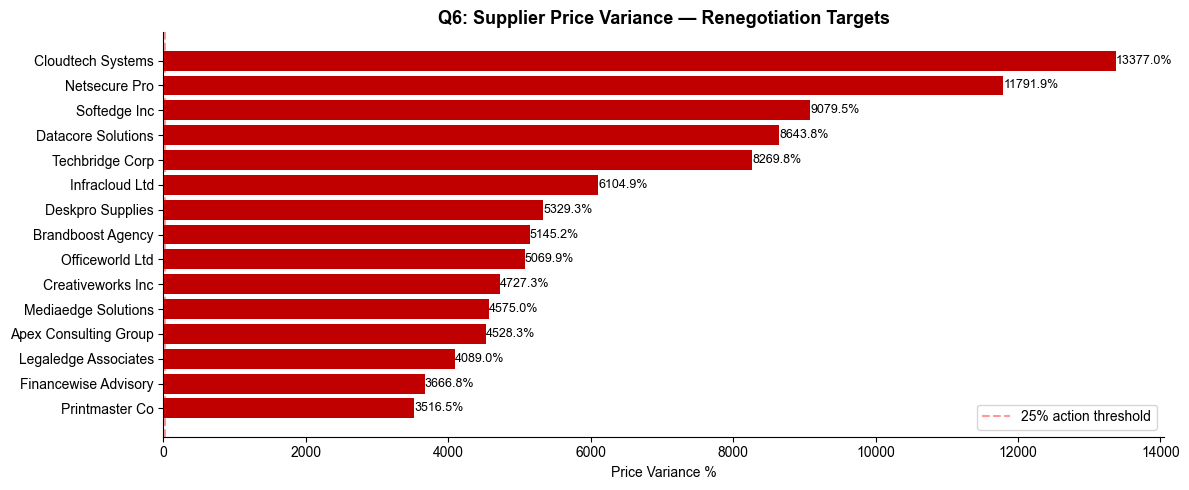


Insight: 15 suppliers with >25% price variance — immediate renegotiation targets


In [11]:
q6 = """
SELECT
    "Supplier_Name" AS supplier_name,
    "Category" AS category,
    COUNT(*) AS transaction_count,
    ROUND(CAST(MIN("Unit_Price") AS numeric), 2) AS min_price,
    ROUND(CAST(MAX("Unit_Price") AS numeric), 2) AS max_price,
    ROUND(CAST(AVG("Unit_Price") AS numeric), 2) AS avg_price,
    ROUND(CAST((MAX("Unit_Price") - MIN("Unit_Price")) * 100.0 
          / NULLIF(MIN("Unit_Price"), 0) AS numeric), 1) AS price_variance_pct
FROM procurement
GROUP BY "Supplier_Name", "Category"
HAVING COUNT(*) >= 10
ORDER BY price_variance_pct DESC
LIMIT 15;
"""

df_q6 = pd.read_sql(text(q6), engine)
display(df_q6)

# Visualize
fig, ax = plt.subplots()
bar_colors = ['#C00000' if x > 50 else '#E97132' if x > 25 else '#2E75B6' for x in df_q6['price_variance_pct']]
bars = ax.barh(df_q6['supplier_name'][::-1], df_q6['price_variance_pct'][::-1], color=bar_colors[::-1])
for bar, val in zip(bars, df_q6['price_variance_pct'][::-1]):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val}%', va='center', fontsize=9)
ax.set_xlabel('Price Variance %')
ax.set_title('Q6: Supplier Price Variance — Renegotiation Targets', fontsize=13, fontweight='bold')
ax.axvline(x=25, color='red', linestyle='--', alpha=0.4, label='25% action threshold')
ax.legend()
plt.tight_layout()
plt.savefig('sql_q6_price_variance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nInsight: {len(df_q6[df_q6['price_variance_pct'] > 25])} suppliers with >25% price variance — immediate renegotiation targets")

## SQL Analysis Summary
| Query | Business Question | Key Finding |
| Q1 | Where is money going? | Professional Services & IT = 50%+ of spend |
| Q2 | Who are our biggest suppliers? | Top 5 suppliers = majority of spend |
| Q3 | How much is off-contract? | Marketing & Sales highest maverick risk |
| Q4 | How has spend trended? | Consistent growth with seasonal patterns |
| Q5 | Where can we consolidate? | Multiple categories highly fragmented |
| Q6 | Who is overcharging? | Several suppliers with 25%+ price increases |

In [12]:
df_main = pd.read_csv('procurement_cleaned.csv')

# Make sure dates are strings for Power BI web compatibility
df_main['PO_Date'] = pd.to_datetime(df_main['PO_Date']).dt.strftime('%Y-%m-%d')
df_main['Invoice_Date'] = pd.to_datetime(df_main['Invoice_Date']).dt.strftime('%Y-%m-%d')
df_main['Payment_Date'] = pd.to_datetime(df_main['Payment_Date']).dt.strftime('%Y-%m-%d')

df_main.to_excel('dashboard_main.xlsx', index=False)
print(f"Main file ready: {len(df_main):,} rows")

Main file ready: 10,000 rows


In [13]:
df_cat = pd.read_sql(text(q1), engine)
df_cat.to_excel('dashboard_category_summary.xlsx', index=False)
print("Category summary ready")
display(df_cat)

Category summary ready


,Category,total_POs,Unique_Suppliers,Total_Spend,pct_of_total
0,Professional Services,1199,34,3.201749e+08,31.62
1,IT & Software,1401,35,2.214203e+08,21.87
2,Logistics,1645,40,1.764012e+08,17.42
3,Raw Materials,2166,42,1.513012e+08,14.94
4,Marketing,373,17,7.226167e+07,7.14
5,MRO,1806,36,3.575323e+07,3.53
6,Facilities,795,24,3.160839e+07,3.12
7,Office Supplies,615,21,3.670458e+06,0.36


In [14]:
df_sup = pd.read_sql(text(q2), engine)
df_sup.to_excel('dashboard_supplier_summary.xlsx', index=False)
print("Supplier summary ready")
display(df_sup)

Supplier summary ready


,supplier_name,category,po_count,total_spend,avg_unit_price,pct_of_total
0,Apex Consulting Group,Professional Services,330,90890608.14,11436.51,8.98
1,Strategyfirst Partners,Professional Services,264,68596249.93,10695.76,6.77
2,Cloudtech Systems,IT & Software,357,62513079.65,7020.61,6.17
3,Legaledge Associates,Professional Services,220,58477227.74,10250.25,5.78
4,Financewise Advisory,Professional Services,200,51254759.18,9821.94,5.06
5,Swiftlogistics Group,Logistics,402,48445028.71,4669.96,4.78
6,Datacore Solutions,IT & Software,291,44018250.74,6175.35,4.35
7,Steelcore Industries,Raw Materials,514,39003100.09,2970.29,3.85
8,Netsecure Pro,IT & Software,227,34672441.26,5980.40,3.42
9,Hrpro Consultants,Professional Services,129,34504527.63,9856.60,3.41


In [16]:
df_mav = pd.read_sql(text(q3), engine)
df_mav.to_excel('dashboard_maverick_summary.xlsx', index=False)
print("Maverick summary ready")
display(df_mav)

Maverick summary ready


,business_unit,total_spend,maverick_spend,contract_spend,maverick_pct
0,Marketing,1.080105e+08,47075295.82,6.093523e+07,43.6
1,Sales,1.034149e+08,37532265.88,6.588258e+07,36.3
2,R&D,6.582324e+07,22526877.52,4.329636e+07,34.2
3,Operations,2.524626e+08,74239019.38,1.782236e+08,29.4
4,IT,1.553790e+08,39466407.90,1.159126e+08,25.4
5,Supply Chain,1.371076e+08,27639540.58,1.094681e+08,20.2
6,HR,7.425242e+07,14639755.12,5.961266e+07,19.7
7,Finance,1.161411e+08,19406113.33,9.673500e+07,16.7


In [17]:
df_pv = pd.read_sql(text(q6), engine)
df_pv.to_excel('dashboard_price_variance.xlsx', index=False)
print("Price variance ready")
display(df_pv)

Price variance ready


,supplier_name,category,transaction_count,min_price,max_price,avg_price,price_variance_pct
0,Cloudtech Systems,IT & Software,357,114.95,15491.82,7020.61,13377.0
1,Netsecure Pro,IT & Software,227,108.31,12880.15,5980.40,11791.9
2,Softedge Inc,IT & Software,185,132.88,12197.73,5639.84,9079.5
3,Datacore Solutions,IT & Software,291,148.33,12969.68,6175.35,8643.8
4,Techbridge Corp,IT & Software,163,152.22,12740.53,6478.91,8269.8
5,Infracloud Ltd,IT & Software,118,200.01,12410.35,5669.52,6104.9
6,Deskpro Supplies,Office Supplies,199,10.00,542.93,239.26,5329.3
7,Brandboost Agency,Marketing,122,288.61,15138.20,7062.12,5145.2
8,Officeworld Ltd,Office Supplies,242,10.28,531.47,238.42,5069.9
9,Creativeworks Inc,Marketing,103,335.38,16189.68,7728.43,4727.3


In [18]:
df_trend = pd.read_sql(text(q4), engine)
df_trend['month'] = pd.to_datetime(df_trend['month']).dt.strftime('%Y-%m-%d')
df_trend.to_excel('dashboard_monthly_trend.xlsx', index=False)
print("Monthly trend ready")
display(df_trend)

Monthly trend ready


,month,monthly_spend,po_count,active_suppliers
0,2023-01-01,55358855.42,575,42
1,2023-02-01,53027897.71,525,42
2,2023-03-01,54410096.69,562,42
3,2023-04-01,56305417.64,533,42
4,2023-05-01,55816634.02,554,42
5,2023-06-01,56005250.82,551,42
6,2023-07-01,55878286.08,567,42
7,2023-08-01,60226115.15,565,42
8,2023-09-01,47306432.59,500,42
9,2023-10-01,66329606.85,577,42


In [19]:
import os
files = [f for f in os.listdir('.') if f.startswith('dashboard_')]
print("Dashboard files ready:")
for f in files:
    size = os.path.getsize(f)
    print(f"  {f} — {size/1024:.1f} KB")

Dashboard files ready:
  dashboard_monthly_trend.xlsx — 5.8 KB
  dashboard_main.xlsx — 1014.8 KB
  dashboard_price_variance.xlsx — 6.3 KB
  dashboard_category_summary.xlsx — 5.7 KB
  dashboard_maverick_summary.xlsx — 5.7 KB
  dashboard_supplier_summary.xlsx — 6.5 KB
